<h1 style="font-family: Cambria; text-align: center;">
Test
</h1>

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

<h2 style="font-family: Cambria; text-align: center;">
Task 1: Load Trained Model and Predict
</h2>

In [2]:
sys.path.append(os.path.abspath('../src'))
from dataset import FlowDataset
from models import HybridUNet

In [3]:
SEED = 42
np.random.seed(SEED)

In [4]:
def load_model_and_predict(config, sample_index=None):
    """
    Loads the model to perform inference.
    
    Args:
        config (dict): Configuration dictionary containing data paths and model parameters.
        sample_index (int, optional): Specific dataset index to verify. If None, selects randomly.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Initialize Dataset (Validation Mode).
    print(f"Loading dataset: {config['data_path']} ...")
    dataset = FlowDataset(
        file_path=config["data_path"], 
        mode="val",
        spatial_crop_size=config["spatial_crop_size"],
        num_spatial_crops=1
    )
    
    # 2. Select a sample.
    if sample_index is None:
        sample_index = np.random.randint(len(dataset))
    
    print(f"Fetching sample ID: {sample_index} ...")
    inputs, targets, dt = dataset[sample_index]

    # 3. Add Batch dimension (B, C, D, H, W) and move to GPU.
    inputs = inputs.unsqueeze(0).to(device)
    targets = targets.unsqueeze(0).to(device)
    dt = dt.unsqueeze(0).to(device)

    # 4. Load Model.
    print("Loading model...")
    model = HybridUNet(
        in_channels=4, 
        out_channels=4, 
        base_dim=32, 
        time_emb_dim=128
    ).to(device)
    
    checkpoint_path = os.path.join(config["checkpoint_dir"], "best_model.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        print(f"Successfully loaded weights: {checkpoint_path}")
    else:
        print(f"Warning: Weights file {checkpoint_path} not found. Using random initialization for testing.")

    # 5. Inference.
    model.eval()
    with torch.no_grad():
        preds = model(inputs, dt)

    return targets.squeeze(0).cpu().numpy(), preds.squeeze(0).cpu().numpy()

<h2 style="font-family: Cambria; text-align: center;">
Task 2: Visualization of Residuals and Flowfields
</h2>

In [5]:
CONFIG = {
    "data_path": "/data1/wangteng/processed/channel_flow.hdf5",
    "checkpoint_dir": "./checkpoints",
    "spatial_crop_size": (32, 32, 32),
}

<div style="font-family: Cambria;">
Function for visualizing residuals.
</div>

In [6]:
def visualize_residuals(target, prediction, slice_idx=16):
    """
    Visualizes velocity magnitude and residuals on a specific slice.
    
    Args:
        target      (np.ndarray): Ground truth with shape [C, D, H, W].
        prediction  (np.ndarray): Model prediction with shape [C, D, H, W]
        slice_idx   (int)       : The Z-axis index of the slice to visualize.
    """
    print("Visualizing residuals...")
    
    target_mag = np.sqrt(np.sum(target[ : 3] ** 2, axis=0))
    pred_mag = np.sqrt(np.sum(prediction[ : 3] ** 2, axis=0))
    residual = np.abs(target_mag - pred_mag)
    
    # Extract middle slice (Z-axis).
    t_slice = target_mag[slice_idx, :, :]
    p_slice = pred_mag[slice_idx, :, :]
    r_slice = residual[slice_idx, :, :]
    
    # Plotting.
    _, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    im1 = axes[0].imshow(t_slice, cmap='jet')
    axes[0].set_title('Ground Truth')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(p_slice, cmap='jet')
    axes[1].set_title('Prediction')
    plt.colorbar(im2, ax=axes[1])
    
    im3 = axes[2].imshow(r_slice, cmap='inferno')
    axes[2].set_title('Residual')
    plt.colorbar(im3, ax=axes[2])
    
    plt.suptitle(f'Residual Analysis at Slice Z={slice_idx}')
    plt.show()

<div style="font-family: Cambria;">
Function for visualizing slices of the flowfield.
</div>

In [7]:
def visualize_flow_vectors(target, prediction, slice_idx=16):
    """
    Visualizes flow field vectors using Quiver plots.
    
    Args:
        target      (np.ndarray): Ground truth with shape [C, D, H, W].
        prediction  (np.ndarray): Model prediction with shape [C, D, H, W].
    """
    print("Visualizing flow field vectors...")
    
    # Extract u, v components for 2D plane plotting.
    u_pred = prediction[0, slice_idx, :, :]
    v_pred = prediction[1, slice_idx, :, :]
    
    u_true = target[0, slice_idx, :, :]
    v_true = target[1, slice_idx, :, :]
    
    # Downsample to avoid overly dense arrows (step=4 means take 1 arrow every 4 pixels).
    step = 4
    Y, X = np.mgrid[0:u_pred.shape[0]:step, 0:u_pred.shape[1]:step]
    
    u_pred_s = u_pred[::step, ::step]
    v_pred_s = v_pred[::step, ::step]
    u_true_s = u_true[::step, ::step]
    v_true_s = v_true[::step, ::step]
    
    _, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Ground Truth Flow Field.
    axes[0].quiver(X, Y, u_true_s, v_true_s, color='g', scale=20)
    axes[0].set_title('Ground Truth Flow Field (Vectors)')
    axes[0].invert_yaxis()

    # Predicted Flow Field.
    axes[1].quiver(X, Y, u_pred_s, v_pred_s, color='b', scale=20)
    axes[1].set_title('Predicted Flow Field (Vectors)')
    axes[1].invert_yaxis()
    
    plt.show()

<div style="font-family: Cambria;">
Execution.
</div>

Using device: cuda
Loading dataset: /data1/wangteng/processed/channel_flow.hdf5 ...
FlowDataset initialized.
    Total Snapshots: 21
    Total items    : 441
Fetching sample ID: 0 ...
Loading model...
Visualizing residuals...


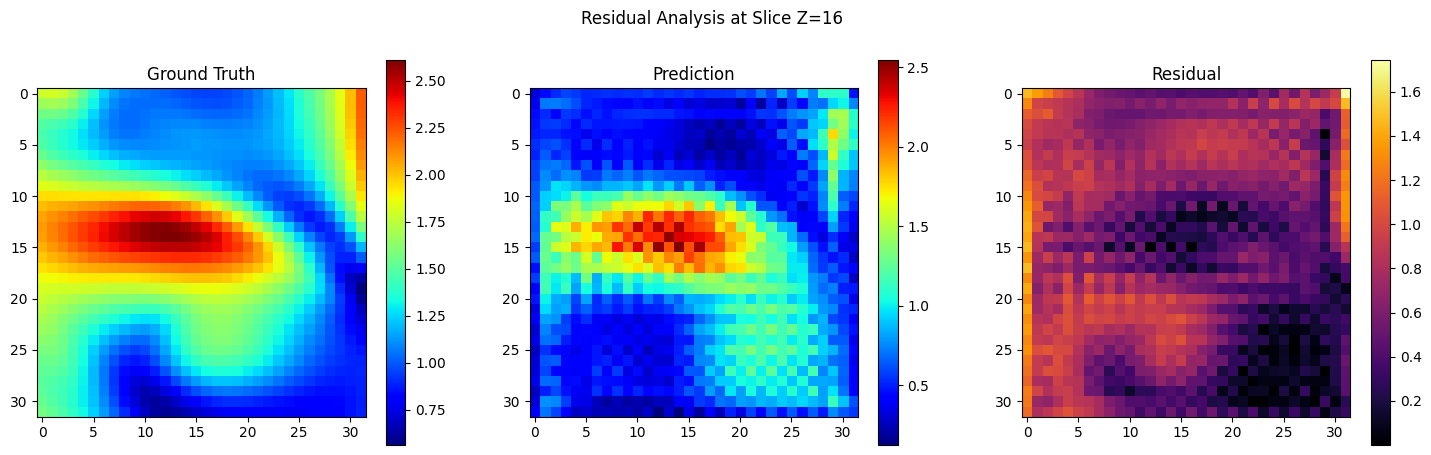

Visualizing flow field vectors...


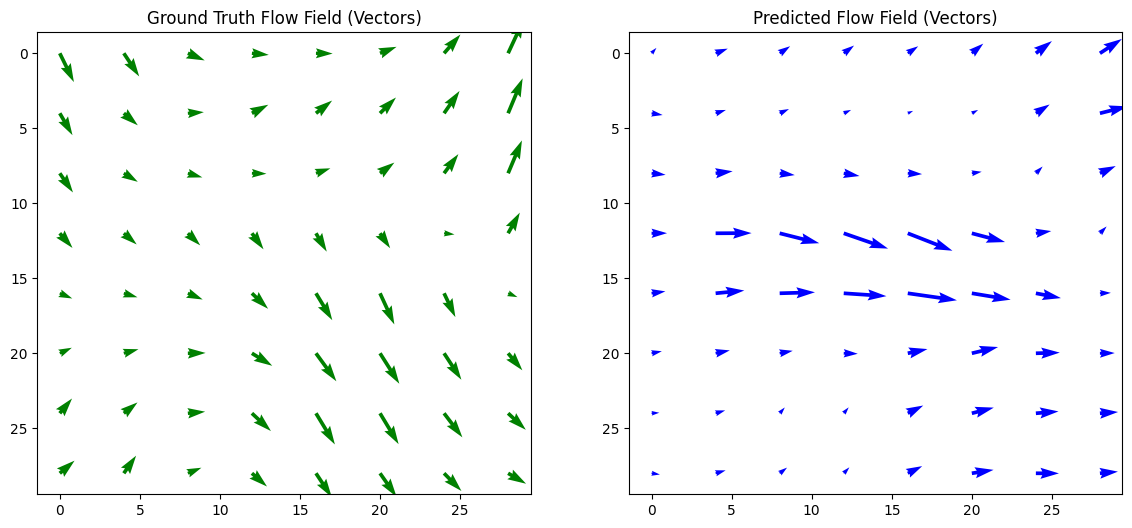

In [8]:
try:
    # Get Data and Prediction.
    target_flow, pred_flow = load_model_and_predict(CONFIG, sample_index=0)
        
    # 3. Visualize Residuals (Select middle slice Z=16).
    visualize_residuals(target_flow, pred_flow, slice_idx=16)
        
    # 4. Visualize Flow Vectors.
    visualize_flow_vectors(target_flow, pred_flow, slice_idx=16)
        
except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
except Exception as e:
    print(f"An error occurred: {e}")